## Rock-Paper-Scissors classification notebook

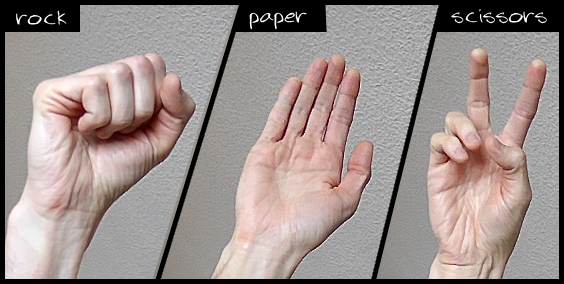  

This is the main notebook of the project. It will load a trained model and apply it to a ROI of your webcam frames.  
A prediction mode will classify hand gestures as rock, paper or scissors.  
A capture mode will let you capture new frames to expand your dataset.  
See readme for more info.  

In [3]:
import os
import cv2
import numpy as np
from datetime import datetime, timedelta
from keras.preprocessing import image
from tensorflow.keras.models import load_model

# BGR COLORS ---------------------------------------------------------------------------------------
log_clr_text = (255, 255, 255)
help_clr_text = (255, 255, 255)
log_clr_background = (0, 0, 0)
help_clr_background = (0, 0, 0)
# CAPTURE WINDOW -----------------------------------------------------------------------------------
window_name = "Rock-Paper-Scissors"
capture_width = 1280
capture_height = 720
# ROI ----------------------------------------------------------------------------------------------
default_roi_dim = 10, 10, 300, 300  # x, y, w, h
settings_path = "settings.txt"  # store some settings to file for next settion, None to disable
roi_size_step = 5  # step to increase or decrease ROI size with the mouse wheel
roi_label_height = 20
roi_clr_default = (0, 255, 0)
roi_clr_selection = (0, 200, 0)
roi_clr_background = (200, 200, 200)
roi_clr_label = (255, 255, 255)
# CAPTURE SETTINGS ---------------------------------------------------------------------------------
img_folder = "captured"  # image saved as "{img_folder}/{img_prefix}{img_next_id}.{img_extension}"
img_prefix = "image_"
img_next_id = 0  # Starting id for image naming. If existing, the next highest id will be assigned
img_extension = "png"
frames_batch = 200  # how many frames to capture in once session
capture_delay = 250  # time in milliseconds to wait between captures
roi_clr_capturing = (0, 0, 255)
roi_clr_saving = (255, 255, 255)
# PREDICTION SETTINGS ------------------------------------------------------------------------------
default_threshold = 20  # default threshold value to isolate hand from background in ROI
use_threshold = False  # activate threshold at startup, can be toggled with 't' key
display_threshold = False  # display threshold mask over ROI
model = load_model('models/rps_v06_56[epoch]_0.9641[acc]_0.1089[loss]_20240221_1058.h5')  # trained model to load
class_indices = {'paper': 0, 'rock': 1, 'scissors': 2}  # training parameters
class_labels = {v:k for k, v in class_indices.items()}
class_img = {k: f"images/{k}.png" for k in class_indices}
prediction_img_size = 50, 50  # litthe RPS thumbnail added to ROI corner
model_input_size = 150, 150
roi_clr_prediction = (255, 0, 125)
# LOG SETTINGS -------------------------------------------------------------------------------------
show_log = True
log_font = cv2.FONT_HERSHEY_SIMPLEX
log_scale = 0.5
log_thickness = 1
log_x, log_y, log_w, log_h = 0, capture_height - 40, capture_width, capture_height  # bottom bar
# HELP SETTINGS ------------------------------------------------------------------------------------
show_help = False
help_font = cv2.FONT_HERSHEY_SIMPLEX
help_scale = 0.5
help_thickness = 1
help_x, help_y, help_w, help_h = 0, 0, 300, 300  # top left corner
# DEBUG SETTINGS -----------------------------------------------------------------------------------
show_debug = False
#---------------------------------------------------------------------------------------------------

# Access the webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Error: Unable to open webcam")
    exit()

# Define capture window
cap.set(cv2.CAP_PROP_FRAME_WIDTH, capture_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, capture_height)
cv2.namedWindow(window_name)

# Load settings from file or use default values ----------------------------------------------------
try:
    # Load ROI dimensions from file or use default
    with open(settings_path, "r") as f:
        roi_x, roi_y, roi_w, roi_h, threshold_amount = map(int, f.readline().split())
        # reinit ROI if out of bounds
        if any([roi_x < 0, roi_y < 0, roi_w < 0, roi_h < 0, roi_x + roi_w > capture_width, roi_y + roi_h > capture_height]):
            raise ValueError

except FileNotFoundError or ValueError:
    # use default values
    roi_x, roi_y, roi_w, roi_h = default_roi_dim
    threshold_amount = default_threshold

# ROI init settings --------------------------------------------------------------------------------
is_moving_roi = False
roi_mode = "Default"
start_x, start_y = 0, 0
square_color = roi_clr_default
# Capture init settings ----------------------------------------------------------------------------
is_capturing = False
# Prediction init settings -------------------------------------------------------------------------
is_predicting = False
roi_background = None
classify_image = False
predicted_class_label = None

# Mouse event callback function --------------------------------------------------------------------
def mouse_callback(event, mouseX, mouseY, flags, param):
    global roi_x, roi_y, roi_w, roi_h, is_moving_roi, start_x, start_y, roi_background, roi_size_step, use_threshold
    mouse_on_roi = roi_x <= mouseX <= roi_x + roi_w and roi_y <= mouseY <= roi_y + roi_h
    # Left Mouse Down: Check if mouse click is inside ROI ------------------------------------------
    if event == cv2.EVENT_LBUTTONDOWN:
        if mouse_on_roi:
            is_moving_roi = True
            start_x, start_y = mouseX - roi_x, mouseY - roi_y
    # Mouse Move: Update ROI position while dragging -----------------------------------------------
    elif event == cv2.EVENT_MOUSEMOVE:
        if is_moving_roi:
            roi_x = max(0, min(mouseX - start_x, frame.shape[1] - roi_w))
            roi_y = max(0, min(mouseY - start_y, frame.shape[0] - roi_h))
            if use_threshold:
                roi_background = roi.copy()
    # Left Mouse Up: Stop moving ROI ---------------------------------------------------------------
    elif event == cv2.EVENT_LBUTTONUP:
        if is_moving_roi:
            is_moving_roi = False
            if use_threshold:
                roi_background = roi.copy()
    # Right Mouse Up: Reset ROI dims ---------------------------------------------------------------
    # Note: Preventing resizing roi while threshold is active as it can cause unexpected results
    elif event == cv2.EVENT_RBUTTONDOWN and mouse_on_roi and not use_threshold:
        _, _, roi_w, roi_h = default_roi_dim
    # Mouse Wheel Up: Increase ROI size ------------------------------------------------------------
    elif flags > 0 and mouse_on_roi and not use_threshold:
        if roi_x + roi_w + roi_size_step <= capture_width and roi_y + roi_h + roi_size_step <= capture_height:
            roi_w += roi_size_step
            roi_h += roi_size_step
    # Mouse Wheel Down: Decrease ROI size ----------------------------------------------------------
    elif flags < 0 and mouse_on_roi and not use_threshold:
        if roi_w > roi_size_step and roi_h > roi_size_step:
            roi_w -= roi_size_step
            roi_h -= roi_size_step

cv2.setMouseCallback(window_name, mouse_callback)

# MAIN LOOP ----------------------------------------------------------------------------------------
while True:

    # Capture frame-by-frame
    ret, frame = cap.read()
    # Check if the frame is read correctly
    if not ret:
        print("Error: Unable to capture frame")
        break
    # Flip the frame horizontally
    frame = cv2.flip(frame, 1)
    # Get the ROI
    roi = frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
    roi_resized = cv2.resize(roi, model_input_size, interpolation=cv2.INTER_AREA)
    roi_label = ''
    prediction_img = None
    log_str = f"ROI: {roi_x}, {roi_y}, {roi_x+roi_w}, {roi_y+roi_h} {roi_w}/{roi_h} | Mode: {roi_mode}"

    # HANDLE KEY PRESS EVENTS ----------------------------------------------------------------------
    key = cv2.waitKey(1) & 0xFF
    # toogle capturing mode ------------------------------------------------------------------------
    if key == ord('c') and not is_predicting:
        is_capturing = not is_capturing
        if is_capturing:
            roi_mode = "Capturing"
            image_counter = 0
            time_counter = datetime.now()
        else:
            roi_mode = "Default"
    # toogle prediction mode --------------------------------------------------------------------------
    elif key == ord('p') and not is_capturing:
        is_predicting = not is_predicting
        if is_predicting:
            roi_mode = "Predicting"
        else:
            roi_mode = "Default"
    # Space key, capture and classify current ROI --------------------------------------------------
    elif key == 32 and is_predicting:
        classify_image = True
    # Escape key, exit all modes -------------------------------------------------------------------
    elif key == 27:
        is_capturing = False
        is_predicting = False
        is_moving_roi = False
        use_threshold = False
        display_threshold = False
    # toogle activate threshold and visibility -----------------------------------------------------
    elif key == ord('t'):
        if not is_capturing:
            if not use_threshold:
                use_threshold = True
                display_threshold = True
                roi_background = roi.copy()
            elif use_threshold and display_threshold:
                display_threshold = False
            else:
                use_threshold = False
                display_threshold = False
    # store roi background -------------------------------------------------------------------------
    elif key == ord('b'):
        roi_background = roi.copy()
    # increase threshold ---------------------------------------------------------------------------
    elif key == ord('+') and threshold_amount < 255:
        threshold_amount += 1
    # decrease threshold ---------------------------------------------------------------------------
    elif key == ord('-') and threshold_amount > 0:
        threshold_amount -= 1
    # toggle log -----------------------------------------------------------------------------------
    elif key == ord('l'):
        show_log = not show_log
    # toggle help ----------------------------------------------------------------------------------
    elif key == ord('h'):
        show_help = not show_help
    # toggle debug ---------------------------------------------------------------------------------
    elif key == ord('d'):
        show_debug = not show_debug
    # Quit the program -----------------------------------------------------------------------------
    elif key == ord('q'):
        break

    # Activate Threshold in ROI --------------------------------------------------------------------
    threshold_roi = None
    if use_threshold:
        # Convert roi and background to grayscale
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        bkg_gray = cv2.cvtColor(roi_background, cv2.COLOR_BGR2GRAY)
        # Calculate absolute difference
        diff = cv2.absdiff(roi_gray, bkg_gray)
        # Apply adaptative thresholding
        _, mask = cv2.threshold(diff, threshold_amount, 255, cv2.THRESH_BINARY)
        # Apply Gaussian blur
        mask = cv2.GaussianBlur(mask, (1, 1), 0)
        # Perform erosion and dilatation to remove noise and fill holes in hand
        kernel_size = 2
        mask = cv2.erode(mask, np.ones((kernel_size, kernel_size), np.uint8), iterations=1)
        kernel_size = 5
        mask = cv2.dilate(mask, np.ones((kernel_size, kernel_size), np.uint8), iterations=1)
        # Convert mask to 3 channels
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        # Create new background
        new_bkg = np.ones_like(roi) * roi_clr_background
        # Apply mask to copy of roi
        threshold_roi = roi.copy()
        threshold_roi[:, :] = np.where(mask > 10, roi, new_bkg)
        # Display threshold mask over ROI
        if display_threshold:
            frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w] = threshold_roi
        # Add threshold info to log
        log_str += f" | Threshold: On ({'Visible' if display_threshold else 'Hidden'}) - {threshold_amount}"

    # Capturing Mode -------------------------------------------------------------------------------
    if is_capturing:
        if image_counter < frames_batch:
            if datetime.now() - time_counter > timedelta(milliseconds=capture_delay):
                # assign valid image id and name
                image_ids = [int(img.replace(img_prefix, "").replace(f".{img_extension}", ""))
                             for img in os.listdir(img_folder)
                             if img.startswith(img_prefix) and img.endswith(f".{img_extension}")]
                if img_next_id in image_ids:
                    # assign next id
                    img_next_id = max(image_ids) + 1
                filepath = os.path.join(img_folder, f"{img_prefix}{img_next_id}.{img_extension}")
                # Save the ROI image
                if use_threshold and display_threshold:
                    cv2.imwrite(filepath, threshold_roi)
                else:
                    cv2.imwrite(filepath, roi)
                image_counter += 1
                time_counter = datetime.now()
                square_color = roi_clr_saving
            else:
                square_color = roi_clr_capturing
        elif image_counter == frames_batch:
            # reinit counter for next capture
            is_capturing = False
            image_counter = 0

        roi_label = f'Capturing frame {image_counter} / {frames_batch}'
        log_str += f" | Batch: {frames_batch} frames - Delay: {capture_delay} ms"

    # Prediction Mode ---------------------------------------------------------------------------------
    elif is_predicting:
        square_color = roi_clr_prediction

        # Convert and resize ROI as used by the keras model
        roi_predicted = threshold_roi if use_threshold else roi
        roi_resized = cv2.resize(roi_predicted, model_input_size, interpolation=cv2.INTER_AREA)
        roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
        roi_normalized = roi_rgb / 255.0
        roi_expanded = np.expand_dims(roi_normalized, axis=0)

        # Classify the ROI image
        prediction_prob = model.predict(roi_expanded, verbose=0)[0]
        predicted_class_index = np.argmax(prediction_prob)
        predicted_class_label = class_labels[predicted_class_index]
        predicted_class_prob = prediction_prob[predicted_class_index]

        # Display prediction
        if predicted_class_prob < 0.8:
            roi_label = 'Undefined'
        else:
            roi_label = f'{predicted_class_label} ({predicted_class_prob:.2f})'
            prediction_img = class_img[predicted_class_label]

        p_paper, p_rock, p_scissors = (f'{p:.2f}' for p in prediction_prob)
        log_str += f" | Prediction: Rock {p_rock} - Paper {p_paper} - Scissors {p_scissors}"

    # Moving ROI -----------------------------------------------------------------------------------
    elif is_moving_roi:
        square_color = roi_clr_selection

    # Default Mode ---------------------------------------------------------------------------------
    else:
        square_color = roi_clr_default

    # Draw square around the ROI -------------------------------------------------------------------
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_w, roi_y + roi_h), square_color, 2)

    # Add ROI label if defined ---------------------------------------------------------------------
    if roi_label:
        cv2.rectangle(frame, (roi_x, roi_y + roi_h), (roi_x + roi_w, roi_y + roi_h + roi_label_height), square_color, -1)
        position = roi_x, roi_y + roi_h + 15
        cv2.putText(frame, roi_label, position, log_font, log_scale, roi_clr_label, log_thickness, cv2.LINE_AA)

    # Show prediction image if defined -------------------------------------------------------------
    if is_predicting and prediction_img:
        # Load prediction image with alpha channel
        foreground = cv2.imread(prediction_img, cv2.IMREAD_UNCHANGED)
        alpha_channel = foreground[:,:,3]
        rgb_channels = foreground[:,:,:3]

        # Fill background with prediction color
        background = np.ones_like(rgb_channels, dtype=np.uint8) * roi_clr_prediction

        # Alpha factor
        alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255.0
        alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)

        # Add foreground imager to background
        base = rgb_channels.astype(np.float32) * alpha_factor
        white = background.astype(np.float32) * (1 - alpha_factor)
        final_image = (base + white).astype(np.uint8)

        # Resize and display prediction image
        final_image = cv2.resize(final_image, prediction_img_size, interpolation=cv2.INTER_AREA)
        frame[roi_y+roi_h-prediction_img_size[1]:roi_y+roi_h, roi_x+roi_w-prediction_img_size[0]:roi_x+roi_w] = final_image

    # Show help ------------------------------------------------------------------------------------
    if show_help:
        text = ['LeftMouseButton: Move ROI', 'MouseWheel: Resize ROI', 'RightMouseButton: Reset ROI size',
                'C: Toggle Capture Mode', 'P: Toggle Prediction Mode', 'T: Toggle Threshold',
                '+/-: Adjust Threshold Amount', 'B: Update Threshold Background', 'L: Toggle Log',
                'D: Toggle Debug', 'H: Toggle Help', 'ESC: Exit current mode', 'Q: Quit the program']

        cv2.rectangle(frame, (help_x, help_y), (help_x + help_w, help_y + help_h), help_clr_background, -1)
        row_x = help_x + 10
        row_y = help_y + 20
        for line in text:
            position = row_x, row_y
            cv2.putText(frame, line, position, help_font, help_scale, help_clr_text, help_thickness, cv2.LINE_AA)
            row_y += 20

    # Show log -------------------------------------------------------------------------------------
    if show_log:
        cv2.rectangle(frame, (log_x, log_y), (log_x + log_w, log_y + log_h), log_clr_background, -1)
        position = log_x + 10, log_y + 20
        log_str += ' | H: Toggle Help'  # add help info to log
        cv2.putText(frame, log_str, position, log_font, log_scale, log_clr_text, log_thickness, cv2.LINE_AA)

    # Show debug info ------------------------------------------------------------------------------
    if show_debug:
        frame[0:model_input_size[0], 0:model_input_size[1]] = roi_resized

    # Display the frame
    cv2.imshow(window_name, frame)

# Save settings on exit ----------------------------------------------------------------------------
if settings_path:
    try:
        with open(settings_path, "w") as f:
            f.write(f"{roi_x} {roi_y} {roi_w} {roi_h} {threshold_amount}")
    except Exception as e:
        print(f"Unable to save settings to file: {e}")

# Release the webcam and close all windows ---------------------------------------------------------
cap.release()
cv2.destroyAllWindows()
